# Regression: summary   

Roue deviation metric: Only route quality score (check the paper)
                                                                                                                                                                                                                                                                   
  🤖 Neural Network Architectures (3 models)                                                                                                      
                                                                                                                                                  
  - ✅ RNN (standard recurrent neural network)                                                                                                    
  - ✅ CNN (convolutional for spatial patterns)                                                                                                   
  - ✅ Attention (weighted importance mechanism)                                                                                                  
                                                                                                                                                  
  🎯 Regression-Specific Task                                                                                                                     
                                                                                                                                                  
  - ✅ Mean Squared Error (MSE) - Primary loss function                                                                                           
  - ✅ R² Score - Model fit quality metric                                                                                                        
  - ✅ Root Mean Squared Error (RMSE) - Error in original units                                                                                   
  - ✅ Mean Absolute Error (MAE) - Average prediction error                                                                                       
  - ✅ Continuous value prediction - Predicts actual route quality scores (not binary classification)                                             
                                                                                                                                                  
  ✨ Data Processing & Features                                                                                                                   
                                                                                                                                                  
  - ✅ K-Fold Cross-Validation - 10-fold stratified CV                                                                                                                                        
  - ✅ Distance Calculations - Route distance features                                                                                            
  - ✅ Temporal Features - Day of week encoding                                                                                                   
  - ✅ Driver Features - Driver ID embeddings                                                                                                     
  - ✅ Geographic Features - Country detection                                                                                                    
  - ✅ Embedding Layers - Categorical feature embeddings                                                                                          
                                                                                                                                                  
  ⚙️ Training Configuration                                                                                                                       
                                                                                                                                                  
  - Learning rate: 0.001                                                                                                                          
  - Batch size: 512 (larger batch for stability)                                                                                                  
  - Epochs: 100 (longer training for fine-tuning)                                                                                                 
  - Optimizer: Adam                                                                                                                               
  - Regularization: Dropout                                                                                                                       
                                                                                                                                                                                                                                
                                                                                                                                                  
  🔧 Key Utility Functions (28 total)                                                                                                             
                                                                                                                                                  
  - get_model() - Model instantiation                                                                                                             
  - create_actual_route() - Route reconstruction                                                                                                  
  - determine_country() - Geographic classification                                                                                               
  - encode_day_of_week() - Temporal encoding                                                                                                      
  - get_positions() - Location position mapping                                                                                                   
  - compare_model_scores() - Model performance comparison                                                                                         
  - reset_random() / set_seed() - Reproducibility                                                                                                 
                                                                                                                                                  
  📦 Libraries Used                                                                                                                               
                                                                                                                                                  
  - PyTorch (neural networks)                                                                                                                     
  - Pandas (data handling)                                                                                                                        
  - NumPy (numerical operations)                                                                                                                  
  - Scikit-learn (Random Forest, metrics)                                                                                                         
  - Matplotlib & Seaborn (visualization)                                                                                                          
                                                                                                                                                                                                                                                                                  
  Summary: regression_final.ipynb is a complete regression pipeline for predicting continuous route quality scores with 3 model architectures, extensive data processing, K-Fold CV evaluation, and comprehensive metrics for assessing prediction accuracy.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans

In [ ]:
data_stops = pd.read_csv('data/uni_molde_v3.csv', sep=';')

data_stops
data_stops.loc[data_stops['stop_completed_at'].isna(), 'stop_completed_at'] = "-1"
data_stops.loc[data_stops['stop_arrived_at'].isna(), 'stop_arrived_at'] = "-1"

print(data_stops.isnull().sum())


sorted_data_stops = data_stops.sort_values(by='stop_dispatched_at', ascending=True)
sorted_data_stops = sorted_data_stops.reset_index(drop=True)
sorted_data_stops['day_of_week'] = pd.to_datetime(sorted_data_stops['stop_dispatched_at']).dt.day_name()
sorted_data_stops['date'] = pd.to_datetime(sorted_data_stops['stop_dispatched_at']).dt.date

#clustering
locations_df = sorted_data_stops[['current_lat', 'current_lng']]
kmeans = KMeans(n_clusters=5000, random_state=42)
kmeans.fit(locations_df)
sorted_data_stops['cluster'] = kmeans.labels_ + 1

sorted_data_stops['location_id_craft'] = sorted_data_stops.groupby(['current_lat', 'current_lng']).ngroup()+1
with open('output.txt', 'w') as f:
    print(sorted_data_stops.to_string(), file=f)
print('number of groups', sorted_data_stops['location_id_craft'].nunique())

# data_stops_day= sorted_data_stops[sorted_data_stops['day_of_week'] == "Wednesday"]
grouped_df = sorted_data_stops.groupby('driver_workday_id')[['driver_id', 'location_type_id', 'address_id', 'stop_dispatched_at', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'stop_completed_at', 'cluster', 'location_id_craft','day_of_week', 'date', 'location_is_depot']].apply(lambda x: pd.Series({
    'driver_id': x['driver_id'].tolist(),
    'location_type_id': x['location_type_id'].tolist(),
    'planned_route_location': x['address_id'].tolist(),
    'stop_dispatched_at': x['stop_dispatched_at'].tolist(),
    'stop_arrived_at': x['stop_arrived_at'].tolist(),
    'stop_earliest': x['stop_earliest'].tolist(),
    'stop_latest': x['stop_latest'].tolist(),
    'current_lat': x['current_lat'].tolist(),
    'current_lng': x['current_lng'].tolist(),
    'stop_completed_at': x['stop_completed_at'].tolist(),
    'planned_route_cluster': x['cluster'].tolist(),
    'planned_route_craft': x['location_id_craft'].tolist(),
    'day_of_week': x['day_of_week'].tolist(),
    'location_is_depot': x['location_is_depot'].tolist(),
    'date': x['date'].tolist()
})).reset_index()
grouped_df
# grouped_df

In [4]:
routes = grouped_df[grouped_df.apply(lambda row: max(row['stop_dispatched_at']) < min(row['stop_completed_at']), axis=1)]
routes = routes.reset_index(drop=True)
len(routes)

20692

In [ ]:
index_routes_with_na = []
for i in range(len(routes)):
    row = routes.iloc[i]
    if "-1" in row['stop_arrived_at']:
        index_routes_with_na.append(i)
print("The number of routes where one value is NA(arrived time)", len(index_routes_with_na))
print(index_routes_with_na)
routes = routes.drop(index_routes_with_na)
routes.reset_index(drop=True)
#
print(len(routes))

In [6]:
#check if it is the same driver in the route
routes['day_of_week'] = routes['stop_arrived_at'].apply(lambda x: [pd.to_datetime(dt).day_name() for dt in x])

def get_mode(x):
    return pd.Series(x).mode().iloc[0] if not pd.Series(x).mode().empty else np.nan

for i in routes['driver_id']:
    if not all(x == i[0] for x in i):
            print('Not the same driver in the route')
routes['driver_id'] = routes['driver_id'].apply(lambda x : x[0])

routes['day_of_week'] = routes['day_of_week'].apply(get_mode)
routes['date'] = routes['date'].apply(get_mode)

routes['date'] = pd.to_datetime(routes['date'])
routes['last_two_weeks_count'] = routes.apply(lambda row:
                                      routes[(routes['driver_id'] == row['driver_id']) &
                                         (row['date'] - routes['date']).dt.days.between(-14, 0)].shape[0],
                                      axis=1)
routes = routes[(routes['date'] < '2023-12-21') | (routes['date'] > '2024-01-14')]
routes['location_type_id'] = routes['location_type_id'].apply(lambda x: [0 if i == 1 else 1 for i in x])
# routes['location_is_depot'] = routes['location_is_depot'].apply(lambda x: [int(value) for value in x])
routes['location_is_depot'] = routes['location_is_depot'].apply(lambda x: [False if value == 0 else value for value in x])

routes = routes[routes['planned_route_craft'].apply(lambda x: len(x) > 2)]
routes = routes.reset_index(drop=True)

In [8]:
def create_actual_route(df, column):
    res_col = []
    for i in range(len(df)):
        row = df.iloc[i]
        sorted_dates = sorted(row['stop_arrived_at'])
        mapping = {}
        for i, date in enumerate(row['stop_arrived_at']):
            mapping[date] = row[column][i]
        res_val = [mapping[sorted_dates[i]] for i in range(len(sorted_dates))]
        res_col.append(res_val)
    return res_col

def create_actual_route_type(df, column):
    res_col = []
    for i in range(len(df)):
        row = df.iloc[i]
        sorted_dates = sorted(row['stop_arrived_at'])
        mapping = {}
        for i, date in enumerate(row['stop_arrived_at']):
            mapping[date] = row['location_type_id'][i]
        res_val = [mapping[sorted_dates[i]] for i in range(len(sorted_dates))]
        res_col.append(res_val)
    return res_col

routes['actual_route_location'] = create_actual_route(routes, 'planned_route_craft')
routes['actual_route_type'] = create_actual_route_type(routes, 'planned_route_craft')

routes = routes[routes['planned_route_craft'].apply(lambda x: len(x) > 2)]
routes = routes.reset_index(drop=True)
len(routes)

18562

In [9]:
planned_routes = routes[['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'location_is_depot', 'date', 'planned_route_cluster']]
actual_routes = routes['actual_route_location']

In [10]:
planned_routes_list = planned_routes['planned_route_craft'].tolist()
actual_routes_list = actual_routes.tolist()
len(planned_routes_list),len(actual_routes_list)

(18562, 18562)


# Route quality score

In [11]:
from collections import defaultdict
def get_positions(seq):
    d = defaultdict(lambda: [])
    for idx, item in enumerate(seq):
        d[item].append(idx)
    return d

def calculate_route_quality_score(planned_ranks, actual_ranks):
    sum_of_differences = 0
    planned = get_positions(planned_ranks)
    actual = get_positions(actual_ranks)
    for key in planned:
        for i in range(len(planned[key])):
            sum_of_differences += abs(planned[key][i] - actual[key][i])
    max_possible_difference = sum([abs(2 * i - (len(planned_ranks) + 1)) for i in range(1, len(planned_ranks) + 1)])

    # Calculate route quality score
    route_quality_score = 1 - (sum_of_differences / max_possible_difference)
    return route_quality_score

In [ ]:
from collections import defaultdict
def get_positions(seq):
    d = defaultdict(lambda: [])
    for idx, item in enumerate(seq):
        d[item].append(idx)
    return d

def calculate_route_quality_score(planned_ranks, actual_ranks):
    sum_of_differences = 0
    planned = get_positions(planned_ranks)
    actual = get_positions(actual_ranks)
    for key in planned:
        for i in range(len(planned[key])):
            sum_of_differences += abs(planned[key][i] - actual[key][i])
    max_possible_difference = sum([abs(2 * i - (len(planned_ranks) + 1)) for i in range(1, len(planned_ranks) + 1)])

    # Calculate route quality score
    route_quality_score = 1 - (sum_of_differences / max_possible_difference)
    return route_quality_score

In [ ]:
completed_routes_df = pd.DataFrame(columns=['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'score', 'location_is_depot', 'date', 'planned_route_cluster'])
scores = []
for i in range(len(planned_routes_list)):
    score = calculate_route_quality_score(planned_routes_list[i],actual_routes_list[i])
    scores.append(score)
    completed_routes_df = pd.concat([completed_routes_df, pd.DataFrame([planned_routes.iloc[i]]).assign(score=score).reset_index(drop=True)], ignore_index=True)


print(len(completed_routes_df))
# completed_routes_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

edit_distances = [v for v in scores if v != 1]
edit_distances = pd.DataFrame(edit_distances, columns=['Scores'])
edit_distances['Scores'] = pd.to_numeric(edit_distances['Scores'])
edit_distances.describe()
sns.set(style='white')
plt.figure(figsize=(8, 6))

sns.kdeplot(data=edit_distances, color='black', linewidth=2, fill=False, bw_adjust=0.5)

plt.xlabel('RQS', fontsize=20)
plt.ylabel('Probability density', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.grid(False)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

edit_distances = [v for v in scores if v != 1]
# edit_distances = pd.DataFrame(scores, columns=['Scores'])
# edit_distances['Scores'] = pd.to_numeric(edit_distances['Scores'])

sns.set(style='white')
plt.figure(figsize=(8, 6))

sns.kdeplot(data=edit_distances, color='black', linewidth=2, fill=False, bw_adjust=0.5)

plt.xlabel('RQS', fontsize=20)
plt.ylabel('Probability density', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.grid(False)
plt.show()

In [ ]:
final_routes = pd.DataFrame({
    'routes': completed_routes_df['planned_route_craft'].tolist(),
    'actual_routes': completed_routes_df['actual_route_location'].tolist(),
    'driver_id': completed_routes_df['driver_id'].tolist() ,
    'last_two_weeks_count': completed_routes_df['last_two_weeks_count'].tolist(),
    'day_of_week': completed_routes_df['day_of_week'].tolist(),
    'score': completed_routes_df['score'].tolist(),
    'location_is_depot': completed_routes_df['location_is_depot'].tolist(),
    'location_type_id': completed_routes_df['location_type_id'].tolist(),
    # 'distance_route': completed_routes_df['distance_route'].tolist(),
    'current_lat': completed_routes_df['current_lat'].tolist(),
    'current_lng': completed_routes_df['current_lng'].tolist(),
    'date': completed_routes_df['date'].tolist(),
    'arriving_time': completed_routes_df['stop_arrived_at'].tolist(),
})
final_routes['len'] = final_routes['routes'].apply(lambda x: len(x))
final_routes

In [ ]:
def determine_country(lat, lng):
    if 57.5 <= lat <= 71.2 and 4.0 <= lng <= 31.0:
        return 0  # Norway
    elif 54.5 <= lat <= 57.8 and 8.0 <= lng <= 15.0:
        return 1  # Denmark
    else:
        return 1
final_routes['country_flag'] = final_routes.apply(lambda row: determine_country(row['current_lat'][0], row['current_lng'][0]), axis=1)

max([len(i) for i in final_routes['routes']])

In [ ]:
#create dictionary and encode to smaller unique numbers
locations_dic = {}
location_count = {}
k = 1
for row in final_routes['routes']:
   for location in row:
       if location not in locations_dic:
           locations_dic[location] = k
           k += 1
k = 1
print(len(locations_dic))

for row in final_routes['routes']:
   for location in row:
       if location not in location_count:
            location_count[location] = 1
       else:
            location_count[location] += 1


In [ ]:
drivers_dic = {}
k = 1
for driver in final_routes['driver_id']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in final_routes['driver_id']:
    encoding_drivers.append(drivers_dic[driver])
#
final_routes['driver_id_sorted'] = encoding_drivers
final_routes['day_of_week_encoded'] = pd.Categorical(final_routes['day_of_week']).codes+1

def encode_day_of_week(row):
    a = np.zeros((36, 7), dtype=int)
    route_len = row['len']
    day_encoded = row['day_of_week_encoded']
    for i in range(36 - route_len, len(a)):
        a[i][day_encoded-1] = 1
    return a

def encode_day_of_week_simple(row):
    a = np.zeros(7, dtype=int)
    day_encoded = row['day_of_week_encoded']
    a[day_encoded - 1] = 1
    return a

final_routes['experience_feature'] = final_routes.apply(lambda x: x['len'] * [x['last_two_weeks_count']], axis = 1)
final_routes['len_feature'] = final_routes.apply(lambda x: x['len'] * [x['len']], axis = 1)
final_routes['driver_id_feature'] = final_routes.apply(lambda x: x['len'] * [x['driver_id_sorted']], axis = 1)
final_routes['country_flag_feature'] = final_routes.apply(lambda x: x['len'] * [x['country_flag']], axis = 1)
final_routes['day_of_week_feature'] = final_routes.apply(encode_day_of_week, axis = 1)
final_routes['day_of_week_encoded_ext'] = final_routes.apply(encode_day_of_week_simple, axis = 1)

encoding_routes = []
for row in final_routes['routes']:
    encoding_route = []
    for location in row:
        encoding_route.append(locations_dic[location])
    encoding_routes.append(encoding_route)
final_routes['routes'] = encoding_routes

print('correlation', final_routes['len'].corr(final_routes['score']))
print('correlation', max(final_routes['len']))
# final_routes = pd.concat([final_routes, pd.get_dummies(final_routes['driver_id_sorted'], prefix='encoding_drivers')], axis=1)

In [ ]:
final_routes['first_arrival'] = final_routes['arriving_time'].apply(lambda x: x[0])

# Convert to datetime and sort
final_routes['first_arrival'] = pd.to_datetime(final_routes['first_arrival'])
final_routes = final_routes.sort_values('first_arrival').reset_index(drop=True)

# Drop the temporary column
final_routes = final_routes.drop('first_arrival', axis=1)
final_routes

In [ ]:
final_routes['score_cumulative_avg'] = final_routes.groupby(['driver_id_sorted', 'day_of_week'])['score'].transform(
        lambda x: x.expanding().mean()
    )
final_routes['score_avg_total'] = final_routes['score'].expanding().mean()

final_routes['score_cumulative_driver'] = final_routes.groupby(['driver_id_sorted'])['score'].transform(
        lambda x: x.expanding().mean()
    )

# Average benchmark


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
def get_predictions(df, scores_dict):
    def predict(row):
        score = scores_dict.get((row['driver_id_sorted'], row['day_of_week']))
        return score
    return df.apply(predict, axis=1)

extra_to_val = True
def split_group(group):
    n = len(group)
    if n < 4:  # Ensure at least 1 sample for train and 1 each for val and test
        return pd.DataFrame()

    # Calculate sizes for each split
    train_size = max(int(n * 0.8), n - 4)  # Ensure at least 2 samples total for val and test
    val_test_size = n - train_size

    # Always give the extra sample to val when odd
    val_size = (val_test_size + 1) // 2  # This will be larger when val_test_size is odd
    test_size = val_test_size - val_size

    return pd.concat([
        group.iloc[:train_size].assign(split='train'),
        group.iloc[train_size:train_size+val_size].assign(split='val'),
        group.iloc[train_size+val_size:].assign(split='test')
    ])

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

final_routes_split = final_routes.groupby(['driver_id_sorted', 'day_of_week']).apply(split_group).reset_index(drop=True)

drivers_dic = {}
k = 1
for driver in final_routes_split['driver_id_sorted']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in final_routes_split['driver_id_sorted']:
    encoding_drivers.append(drivers_dic[driver])
#
final_routes_split['driver_id_sorted'] = encoding_drivers

locations_dic = {}
k = 1
for row in final_routes_split['routes']:
   for location in row:
       if location not in locations_dic:
           locations_dic[location] = k
           k += 1
print(len(locations_dic))
encoding_routes = []
for row in final_routes_split['routes']:
    encoding_route = []
    for location in row:
        encoding_route.append(locations_dic[location])
    encoding_routes.append(encoding_route)
final_routes_split['routes'] = encoding_routes

# Separate into train, validation, and test sets
print(len(final_routes_split))
train_df = final_routes_split[final_routes_split['split'] == 'train'].drop('split', axis=1)
val_df = final_routes_split[final_routes_split['split'] == 'val'].drop('split', axis=1)
test_df = final_routes_split[final_routes_split['split'] == 'test'].drop('split', axis=1)

print(len(train_df), len(val_df), len(test_df))
combined_df = pd.concat([train_df, val_df, test_df], axis=0)
combined_df = combined_df.reset_index(drop=True)

val_y_true = val_df['score']
average_scores_dict = train_df.groupby(['driver_id_sorted', 'day_of_week'])['score_cumulative_avg'].last().to_dict()
total_avg = train_df['score_avg_total'].iloc[-1]
val_y_pred = get_predictions(val_df, average_scores_dict)
val_mse, val_rmse, val_mae, val_r2 = calculate_metrics(val_y_true, val_y_pred)


# Calculate metrics for test set
test_y_true = test_df['score']
test_y_pred = get_predictions(test_df, average_scores_dict)
test_mse, test_rmse, test_mae, test_r2 = calculate_metrics(test_y_true, test_y_pred)

#Global HA
# test_mse, test_rmse, test_mae, test_r2 = calculate_metrics(test_y_true, [total_avg] * len(test_y_true))

test_df_group_HA = test_df.copy()
test_df_group_HA['prediction'] = test_y_pred
# test_df_group_HA['prediction'] = [total_avg] * len(test_y_true)
# Print results
print("Validation Metrics:")
print(f"MSE: {val_mse}, RMSE: {val_rmse}, MAE: {val_mae}, R2: {val_r2}")
print("\nTest Metrics:")
print(f"MSE: {test_mse}, RMSE: {test_rmse}, MAE: {test_mae}, R2: {test_r2}")
test_df_group_HA[['routes', 'score', 'prediction']]

In [ ]:
def plot_prediction_score_difference(df, model_name):
    # Calculate the prediction error
    df['error'] = df['prediction'] - df['score']

    # Create figure with specific size and DPI for publication quality
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

    # Plot with improved styling
    ax.plot(range(len(df)), df['error'], color='#2878B5', linewidth=1.5, alpha=0.8)
    ax.axhline(y=0, color='#C4323C', linestyle='--', linewidth=1, alpha=0.6)

    # Set axis labels with LaTeX formatting
    ax.set_xlabel('Test instances', fontsize=26)
    ax.set_ylabel('Prediction error', fontsize=26)

    # Set axis limits and grid
    ax.set_ylim(-1, 1)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Calculate and display statistics
    mae = np.abs(df['error']).mean()
    std = np.abs(df['error']).std()
    stats_text = f'MAE: {mae:.3f}\n$\sigma$: {std:.3f}'
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            fontsize=26,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3))

    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print detailed statistics
    print(f"\nStatistical Analysis:")
    print(f"MAE: {mae:.4f}")
    print(f"Standard deviation: {std:.4f}")
    print(f"Min error: {df['error'].min():.4f}")
    print(f"Max error: {df['error'].max():.4f}")

In [ ]:
from scipy import stats
def compare_model_scores(df1, df2):
    diff1 = df1['prediction'] - df1['score']
    diff2 = df2['prediction'] - df2['score']

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(diff1, diff2)
    print(t_stat, p_value)


# After benchmark

In [ ]:
plot_prediction_score_difference(test_df_group_HA, 'HA Model')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming final_routes dataframe is available and sorted by date
# If not, make sure to sort it by date first

# Prepare the data
rf_df = final_routes_split[['driver_id_sorted', 'day_of_week_encoded', 'score', 'split']]
o_day_of = pd.get_dummies(rf_df['day_of_week_encoded'], prefix='day')
o_driver = pd.get_dummies(rf_df['driver_id_sorted'], prefix='driver')
rf_df = pd.concat([o_day_of, o_driver, rf_df['split'], rf_df['score']], axis=1)


for col in rf_df.columns:
    if col != 'split' and col != 'score':
        rf_df[col] = rf_df[col].astype(int)

train_df = rf_df[rf_df['split'] == 'train'].drop('split', axis=1)
val_df = rf_df[rf_df['split'] == 'val'].drop('split', axis=1)
test_df = rf_df[rf_df['split'] == 'test'].drop('split', axis=1)

# Create X_train and y_train
X_train = train_df.drop('score', axis=1)
y_train = train_df['score']

# Create X_val and y_val (optional, but often useful)
X_val = val_df.drop('score', axis=1)
y_val = val_df['score']

# Create X_test and y_test (optional, but often useful)
X_test = test_df.drop('score', axis=1)
y_test = test_df['score']

print(len(train_df), len(val_df), len(test_df))
#
#
# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Evaluate on validation set
y_val_pred = model.predict(X_val)
val_mse, val_rmse, val_mae, val_r2 = calculate_metrics(y_val, y_val_pred)

# Evaluate on test set
y_test_pred = model.predict(X_test)
test_mse, test_rmse, test_mae, test_r2 = calculate_metrics(y_test, y_test_pred)

# Print metrics
print("Validation Set Metrics:")
print(f"MSE: {val_mse:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE: {val_mae:.4f}")
print(f"R2: {val_r2:.4f}")

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R2: {test_r2:.4f}")



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import os
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.use_deterministic_algorithms(True)

set_seed(42)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Training settings
num_epochs = 100
learning_rate = 0.001

model = SimpleNN(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
best_val_loss = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Load the best model
model.load_state_dict(best_model)

# Evaluation on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_true = y_test_tensor

y_pred = y_pred.numpy()
y_true = y_true.numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\nTest Set Metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

train_df

# Model

In [ ]:
def padding_(routes, route_len):
    features = np.zeros((len(routes), route_len),dtype=np.float16)
    for ii, route in enumerate(routes):
        if len(route) != 0:
            features[ii, -len(route):] = np.array(route)[:route_len]
    return features

X = final_routes_split.drop(columns = ['driver_id', 'len', 'driver_id_sorted','day_of_week_encoded'])
max_route_length = max(len(item) for item in final_routes_split['routes'])
y = np.array(final_routes_split['score'])
final_routes_split

# Driver id and location id counting with transformed dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import random

seed_value = 42
device = "cpu"


g = torch.Generator()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Additional steps if using DataLoaders (to ensure reproducibility in data loading)
torch.use_deterministic_algorithms(True)

def reset_random():
    g.manual_seed(seed_value)
    torch.manual_seed(seed_value)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.use_deterministic_algorithms(True)

set_seed(42)

In [ ]:
import torch #pytorch
import torch.nn as nn

In [ ]:
class PredictionRNN(nn.Module):
    def __init__(self,no_layers,vocab_size, vocab_size_driv, vocab_size_len,hidden_dim,embedding_dim,embedding_dim_driv, output_dim,additional_feature_count,drop_prob=0.5):
        super(PredictionRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.vocab_size_driv = vocab_size_driv
        self.vocab_size_len = vocab_size_len

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)
        # embedding_dim_driv+2
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)


        # dropout layer

        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        # self.fc = nn.Linear(self.hidden_dim, output_dim)
        # self.fc_static_1 = nn.Linear(embedding_dim_driv+embedding_dim_len+9, 16)
        self.fc_static_1 = nn.Linear(embedding_dim_driv+10, 128)
        # self.fc_static_2 = nn.Linear(128, 128)
        # # self.fc = nn.Linear(36, output_dim)
        # # self.fc = nn.Linear(1316, output_dim)
        self.fc = nn.Linear(128+64,128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sig = nn.Sigmoid()

    def forward(self,x):
        batch_size = len(x['routes'])
        route_ids = x['routes'].int()

        embeds = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        # get driver ids example
        driver_ids = x['driver_id_sorted'].int()
        experience = x['last_two_weeks_count'].int()
        len_feature = x['len'].float()
        # distance = x['distance_route'].int()
        day_of_week_feature = x['day_of_week_encoded_ext'].float()
        country_flag = x['country_flag'].int()
        location_is_depot = x['location_is_depot'].int()
        location_type_id = x['location_type_id'].int()
        # print('location_type_id', location_type_id.shape)
        # location_type_id = F.one_hot(location_type_id, num_classes=2).float()
        # raise 'ere'


        embedding_driv = self.embedding_driv(driver_ids)
        # print('embedding_driv', embedding_driv.shape)
        # ,distance.view(batch_size, max_route_length, 1)
        # experience.view(batch_size, max_route_length, 1)
        # distance.view(batch_size, max_route_length, 1), location_is_depot.view(batch_size, max_route_length, 1)
        # location_type_id.view(batch_size, max_route_length, 1)
        all_embeds = torch.concatenate((embeds, location_type_id.view(batch_size, max_route_length, 1)), dim=2)
        # location_is_depot.view(batch_size, max_route_length, 1)
        # print('all_embeds', all_embeds.shape)
        # all_embeds = torch.concatenate((embeds, location_type_id), dim=2)
        all_embeds = embeds
        # print(all_embeds.shape)

        # all_static = torch.concatenate((embedding_driv, embedding_len, day_of_week_feature, country_flag.view(batch_size, 1),experience.view(batch_size, 1)), dim=1)
        # len_feature.view(batch_size, 1)
        # experience.view(batch_size, 1)
        # experience.view(batch_size, 1), len_feature.view(batch_size, 1)
        all_static = torch.concatenate((embedding_driv, day_of_week_feature, country_flag.view(batch_size, 1), len_feature.view(batch_size, 1), experience.view(batch_size, 1)), dim=1)
        # all_static = torch.concatenate((embedding_driv, day_of_week_feature), dim=1)


        lstm_out, _ = self.lstm(all_embeds)
        lstm_out = lstm_out.contiguous().view(batch_size, max_route_length, self.hidden_dim)
        out = self.dropout(lstm_out)

        out_static = self.relu(self.fc_static_1(all_static))
        # out_static = self.dropout(self.fc_static_2(out_static))
        # out_static = out_static.unsqueeze(1)
        # print(out.shape, out_static.shape)
        # out = self.fc(torch.concatenate((out, out_static), dim=1))
        out_static = out_static.squeeze(1).unsqueeze(1).repeat(1, 36, 1)  # New shape: [2048, 36, 64]
        out = self.fc(torch.cat((out, out_static), dim=2))
        # out = self.fc(out_static)
        x = self.relu(out)
        # x = self.relu(self.layer2(x))
        x = self.layer3(x)
        # print(out.shape)
        # sigmoid function
        sig_out = self.sig(x)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        return sig_out

In [ ]:
def get_model():
    no_layers = 2
    vocab_size = 10548 #extra 1 for padding
    vocab_size_driv = 317
    vocab_size_len = 37 #extra 1 for padding
    embedding_dim = 64 #was 64
    embedding_dim_driv = 32 #was 64
    # embedding_dim_len = 2 #was 64
    output_dim = 1
    hidden_dim = 64 #was 64


    model = PredictionRNN(no_layers,vocab_size, vocab_size_driv, vocab_size_len, hidden_dim,embedding_dim, embedding_dim_driv, output_dim,len(drivers_dic),drop_prob=0.5)
    # model = PredictionAllFeaturesCNN(no_layers, vocab_size, vocab_size_driv, embedding_dim, embedding_dim_driv, output_dim, drop_prob=0.5)
    # model = NanoTransformer(embedding_dim, vocab_size, embedding_dim_driv, vocab_size_driv)
    model.train()
    print(model)
    return model

In [229]:
# function to predict accuracy
# def acc(pred,label):
#     pred = torch.round(pred.squeeze())
#     return torch.sum(pred == label.squeeze()).item()

def rmse(pred, label):
    return torch.sqrt(torch.mean((pred.squeeze() - label.squeeze())**2))

# def get_precision(pred, label):
#     pred = torch.round(pred.squeeze())
#     true_positive = torch.sum((pred == 1) & (label.squeeze() == 1)).item()
#     false_positive = torch.sum((pred == 1) & (label.squeeze() == 0)).item()
#
#     if true_positive + false_positive == 0:
#         return 0.0, true_positive, false_positive  # Handle the case where there are no predicted positives
#
#     precision_value = true_positive / (true_positive + false_positive)
#     return precision_value, true_positive, false_positive

In [230]:
RUN_NAME = 'first_run_4'
def train_model(data, model, epochs = 20):
    train_loader, valid_loader = data
    lr=0.001

    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    clip = 5
    valid_loss_min = np.Inf
    # train for some number of epochs
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]
    epoch_tr_precision,epoch_vl_precision = [],[]
    # wandb.init(project='Route_classification', name=f'{run_name}')

    for epoch in range(epochs):
        train_losses = []
        train_rmse = 0.0
        model.train()
        for inputs, labels in train_loader:
            # print(labels)

            model.zero_grad()
            # print(inputs.shape, h[0].shape, h[1].shape)
            output = model(inputs)

            # calculate the loss and perform backprop
            # print(output, labels)
            # print(output.shape, labels.shape)
            loss = criterion(output.view(-1), labels.float())
            loss.backward()
            train_losses.append(loss.item())
            train_rmse += rmse(output,labels)
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        val_losses = []
        val_rmse = 0.0
        model.eval()
        for inputs, labels in valid_loader:
                # inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                val_loss = criterion(output.view(-1), labels.float())
                val_losses.append(val_loss.item())
                val_rmse += rmse(output,labels)

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)

        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_train_rmse = train_rmse / len(train_loader)
        epoch_val_rmse = val_rmse / len(valid_loader)
        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_rmse : {epoch_train_rmse} val_rmse : {epoch_val_rmse}')

        if epoch_val_loss <= valid_loss_min:
            torch.save(model.state_dict(), f'{RUN_NAME}.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')

In [231]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def get_stats(model, data):
    model.eval()
    y_pred = []
    y = []
    for inputs, labels in data:
        y.extend(labels)
        results = model(inputs).detach()
        y_pred.extend(results)

    y = np.array(y)
    y_pred = np.array(y_pred)

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "y": y,
        "y_pred":y_pred
    }


In [232]:
from sklearn.preprocessing import StandardScaler
set_seed(42)
FEATURE_COLUMNS = ['routes', 'driver_id_feature', 'driver_id_sorted','last_two_weeks_count', 'len', 'day_of_week_feature', 'day_of_week_encoded_ext', 'country_flag', 'location_is_depot', 'location_type_id']


class DataFrameDataset(Dataset):
    def __init__(self, df, len_scaler=None, two_weeks_scaler=None):
        self.df = df
        self.len_scaler = len_scaler
        self.two_weeks_scaler = two_weeks_scaler


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {}
        for col in FEATURE_COLUMNS:
            feature = self.df[col].iloc[idx]
            if isinstance(feature, list):
                feature = padding_([feature], max_route_length)[0]
            if col == 'len' and self.len_scaler is not None:
                feature_df = pd.DataFrame({'len': [feature]})
                feature = self.len_scaler.transform(feature_df)[0][0]
            elif col == 'last_two_weeks_count' and self.two_weeks_scaler is not None:
                feature_df = pd.DataFrame({'last_two_weeks_count': [feature]})
                feature = self.two_weeks_scaler.transform(feature_df)[0][0]
            item[col] = feature
        item['score'] = self.df['score'].iloc[idx]
        return item, item['score']

def get_data_loaders(train_df, val_df, test_df):

    len_scaler = StandardScaler()
    two_weeks_scaler = StandardScaler()
    is_depot_scaler = StandardScaler()

    len_scaler.fit(train_df[['len']])
    two_weeks_scaler.fit(train_df[['last_two_weeks_count']])
    for df in [train_df, val_df, test_df]:
        df['len'] = len_scaler.transform(df[['len']])
        df['last_two_weeks_count'] = two_weeks_scaler.transform(df[['last_two_weeks_count']])

    # Create Tensor datasets
    train_data = DataFrameDataset(train_df, len_scaler, two_weeks_scaler)
    val_data = DataFrameDataset(val_df, len_scaler, two_weeks_scaler)
    test_data = DataFrameDataset(test_df, len_scaler, two_weeks_scaler)

    # dataloaders 128
    batch_size = 512

    # make sure to SHUFFLE your data
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, generator=g, worker_init_fn=seed_worker)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, generator=g, worker_init_fn=seed_worker)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, generator=g, worker_init_fn=seed_worker)
    return train_loader, val_loader, test_loader

train_df = final_routes_split[final_routes_split['split'] == 'train'].drop('split', axis=1)
val_df = final_routes_split[final_routes_split['split'] == 'val'].drop('split', axis=1)
test_df = final_routes_split[final_routes_split['split'] == 'test'].drop('split', axis=1)

print(f'len(train_df) = {len(train_df)}, len(val_df) = {len(val_df)}, len(test_df) = {len(test_df)}')

train_loader, val_loader, test_loader = get_data_loaders(train_df, val_df, test_df)
# print(test_df)

model = get_model()
model.train()
train_df

# Train the model
train_model((train_loader, val_loader), model, epochs=40)

# Load the best model
model = get_model()
model.load_state_dict(torch.load(f'{RUN_NAME}.pt'))

# Evaluate on test set
model.eval()
test_stats = get_stats(model, test_loader)

print("\nTest Set Metrics:")
print(f"MSE: {test_stats['mse']}")
print(f"RMSE: {test_stats['rmse']}")
print(f"MAE: {test_stats['mae']}")
print(f"R2: {test_stats['r2']}")

len(train_df) = 13823, len(val_df) = 2188, len(test_df) = 1656
PredictionRNN(
  (embedding): Embedding(10548, 64)
  (embedding_driv): Embedding(317, 32)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_static_1): Linear(in_features=42, out_features=128, bias=True)
  (fc): Linear(in_features=192, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (sig): Sigmoid()
)
Epoch 1
train_loss : 0.043205652937844945 val_loss : 0.036957455426454545
train_rmse : 0.2041785575387029 val_rmse : 0.19049471197424278
Validation loss decreased (inf --> 0.036957).  Saving model ...
Epoch 2
train_loss : 0.03805296688720032 val_loss : 0.03173119314014912
train_rmse : 0.18655616749067205 val_rmse : 0.17707524192164006
Validation loss decreased (0.036957 --> 0.031731).  Saving model ...
Epoch 3
train_loss : 0.03286728

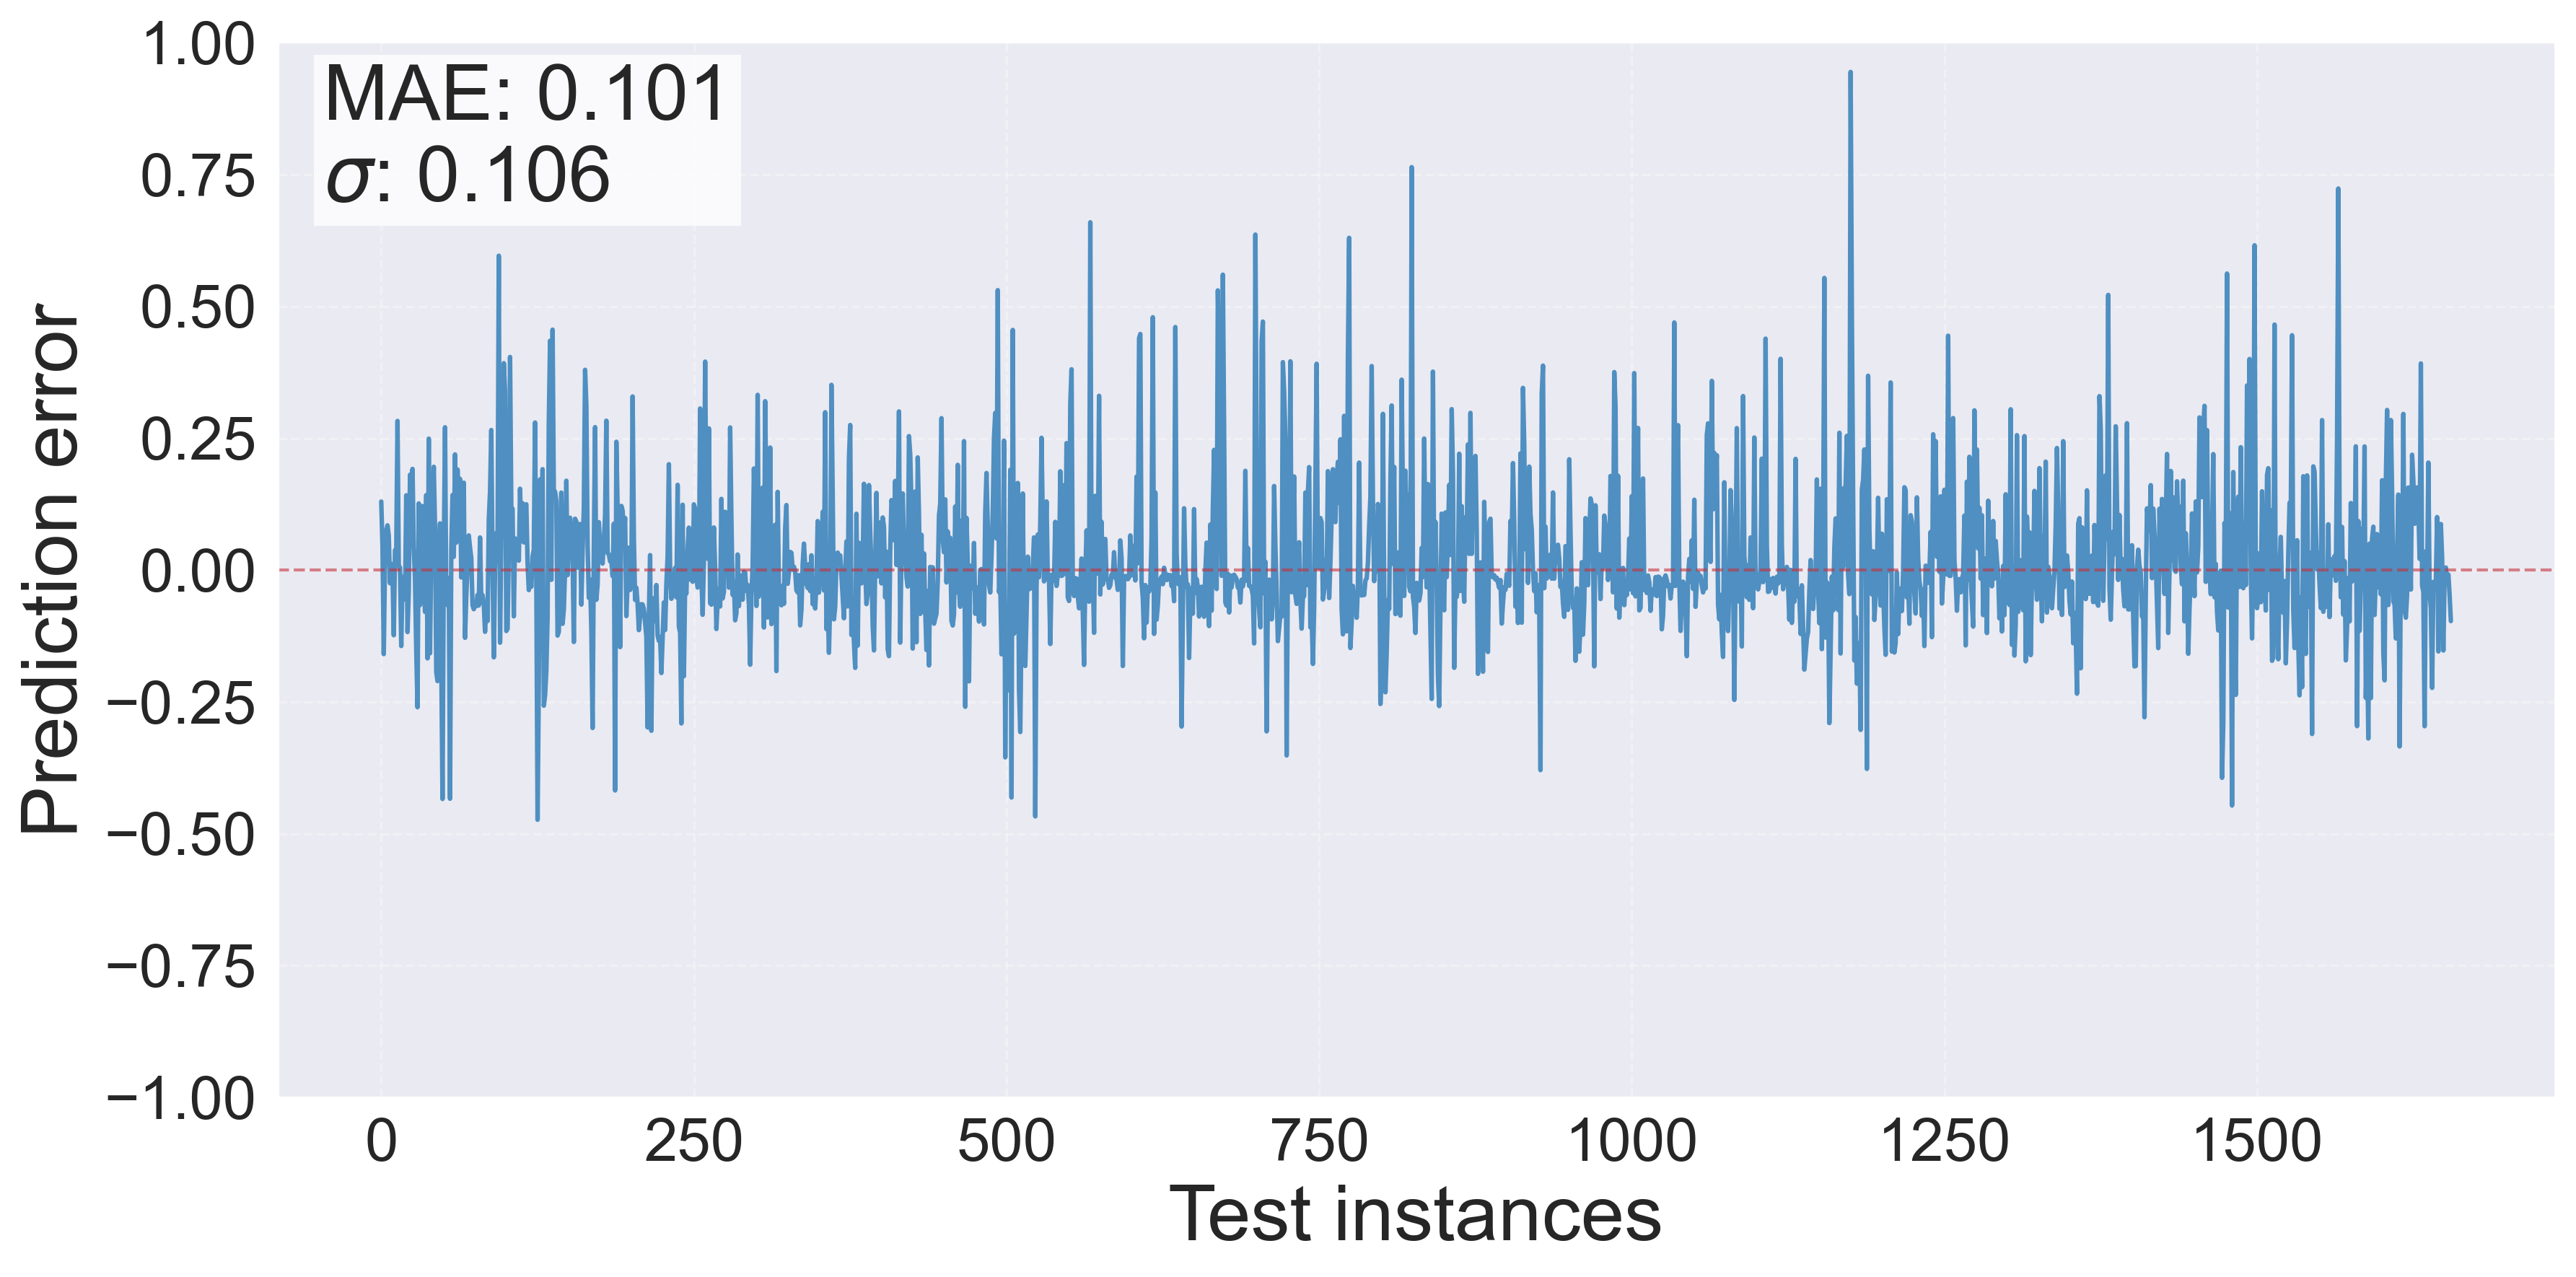


Statistical Analysis:
MAE: 0.1005
Standard deviation: 0.1058
Min error: -0.4733
Max error: 0.9450


In [169]:
test_df_group_LSTM_2 = test_df.copy()
test_df_group_LSTM_2['prediction'] = test_stats['y_pred']
test_df_group_LSTM_2['score'] = test_stats['y']
plot_prediction_score_difference(test_df_group_LSTM_2, 'LSTM Model')

In [163]:
compare_model_scores(test_df_group_HA, test_df_group_LSTM_2)

-6.043584472344396 1.6748998417376327e-09


In [ ]:
print(test_df_group_HA['score'], test_df_group_LSTM_2['score'])


In [ ]:
class PredictionAllFeaturesCNN(nn.Module):
    def __init__(self, no_layers, vocab_size, vocab_size_driv, embedding_dim, embedding_dim_driv, output_dim, drop_prob=0.5):
        super(PredictionAllFeaturesCNN, self).__init__()

        self.no_layers = no_layers
        self.output_dim = output_dim
        self.vocab_size = vocab_size
        self.vocab_size_driv = vocab_size_driv

        # Embedding layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)


        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)
        # embedding_dim_driv+2
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)


        # dropout layer
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)

        self.dropout = nn.Dropout(drop_prob)
        # self.fc = nn.Linear(self.hidden_dim, output_dim)
        # self.fc_static_1 = nn.Linear(embedding_dim_driv+embedding_dim_len+9, 16)
        self.fc_static_1 = nn.Linear(embedding_dim_driv+9, 128)
        # self.fc_static_2 = nn.Linear(128, 128)
        # # self.fc = nn.Linear(36, output_dim)
        # # self.fc = nn.Linear(1316, output_dim)
        self.fc = nn.Linear(128+64,64)
        # # self.fc = nn.Linear(128,128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x, is_training=True):
        batch_size = len(x['routes'])
        route_ids = x['routes'].int()

        embeds = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        # get driver ids example
        driver_ids = x['driver_id_sorted'].int()
        experience = x['last_two_weeks_count'].int()
        len_feature = x['len'].int()
        # distance = x['distance_route'].int()
        day_of_week_feature = x['day_of_week_encoded_ext'].int()
        country_flag = x['country_flag'].int()
        location_is_depot = x['location_is_depot'].int()
        location_type_id = x['location_type_id'].int()

        embedding_driv = self.embedding_driv(driver_ids)
        # ,distance.view(batch_size, max_route_length, 1)
        # experience.view(batch_size, max_route_length, 1)

        # all_embeds = torch.concatenate((embeds, distance.view(batch_size, max_route_length, 1), location_is_depot.view(batch_size, max_route_length, 1), location_type_id.view(batch_size, max_route_length, 1)), dim=2)
        all_embeds = embeds

        # all_static = torch.concatenate((embedding_driv, embedding_len, day_of_week_feature, country_flag.view(batch_size, 1),experience.view(batch_size, 1)), dim=1)
        all_static = torch.concatenate((embedding_driv, country_flag.view(batch_size, 1),len_feature.view(batch_size, 1), day_of_week_feature), dim=1)
        # all_static = torch.concatenate((embedding_driv, day_of_week_feature), dim=1)


        cnn_input = embeds.permute(0, 2, 1)  # Reshape for CNN: B x Feature x S
        cnn_out = self.conv1(cnn_input)
        cnn_out = self.relu(cnn_out)
        cnn_out = self.pool(cnn_out)
        # cnn_out = cnn_out.permute(0, 2, 1)
        cnn_out = torch.mean(cnn_out, dim=2)
        cnn_out = self.dropout(cnn_out)

        # lstm_out, _ = self.lstm(cnn_out)
        # # lstm_out = lstm_out.contiguous().view(batch_size, max_route_length, self.hidden_dim)
        # lstm_out = lstm_out.contiguous().view(batch_size, -1, self.hidden_dim)
        # out = self.dropout(lstm_out)

        out_static = self.relu(self.fc_static_1(all_static))
        # out_static = self.dropout(self.fc_static_2(out_static))
        # out_static = out_static.unsqueeze(1)

        combined = self.fc(torch.cat((cnn_out, out_static), dim=1))
        # out = self.fc(torch.concatenate((out, out_static), dim=1))
        # out_static = out_static.squeeze(1).unsqueeze(1).repeat(1, 36, 1)  # New shape: [2048, 36, 64]
        # out = self.fc(torch.cat((out, out_static), dim=2))
        x = self.relu(combined)
        # x = self.relu(self.layer2(out))
        # out = self.dropout(x)
        out = self.layer3(x)
        # print(out.shape)
        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        return sig_out

In [ ]:
import math


class RunningNorm:
    def __init__(self, dim=0):
        self.dim = dim
        self.n = 0
        self.mean = 0
        self.var = 0

    def update(self, x):
        self.n += 1
        if self.n == 1:
            self.mean = x
            self.var = torch.zeros_like(x)
        else:
            new_mean = self.mean + (x - self.mean) / self.n
            self.var = (self.var * (self.n - 1) + (x - self.mean) * (x - new_mean)) / self.n
            self.mean = new_mean

    def normalize(self, x):
        if self.n == 0:
            return x
        return (x - self.mean) / (torch.sqrt(self.var) + 1e-8)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=35):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x.shape should be (batch_size, sequence_length, d_model)
        sequence_length = x.size(1)
        x = x + self.pe[:, :sequence_length, :]
        return x

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# "Encoder-Only" Style Transformer
class NanoTransformer(nn.Module):
    """
    This class implements a simplified Transformer model for sequence classification.
    It uses an embedding layer for tokens, sinusoidal positional embeddings,
    a single Transformer block, and a final linear layer for prediction.

    Args:
      num_emb: The number of unique tokens in the vocabulary.
      output_size: The size of the output layer (number of classes).
      hidden_size: The dimension of the hidden layer in the Transformer block (default: 128).
      num_heads: The number of heads in the multi-head attention layer (default: 4).
    """
    def __init__(self, embedding_dim, vocab_size, embedding_dim_driv, vocab_size_driv, hidden_size=64, num_heads=4):
        super(NanoTransformer, self).__init__()

        # Create an embedding for each token
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        self.hidden_size = hidden_size
        self.embedding_dim_driv = embedding_dim_driv
        self.vocab_size_driv = vocab_size_driv

        self.pos_emb = SinusoidalPosEmb(hidden_size)

        self.multihead_attn1 = nn.MultiheadAttention(hidden_size, num_heads=num_heads, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc_static_1 = nn.Linear(embedding_dim_driv+9, 128)
        self.layer3 = nn.Linear(128, 1)
        self.fc = nn.Linear(hidden_size+128, 64)
        self.layer3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()



    def forward(self, x, is_training=True):
        bs = len(x['routes'])
        l = len(x['routes'][0])
        route_ids = x['routes'].int()
        input_embs = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        driver_ids = x['driver_id_sorted'].int()
        experience = x['last_two_weeks_count'].float()
        len_feature = x['len'].float()
        day_of_week_feature = x['day_of_week_encoded_ext'].int()
        country_flag = x['country_flag'].int()
        location_is_depot = x['location_is_depot'].int()
        location_type_id = x['location_type_id'].int()

        embedding_driv = self.embedding_driv(driver_ids)

        all_static = torch.cat((embedding_driv, country_flag.view(bs, 1),
                                len_feature.view(bs, 1), day_of_week_feature), dim=1)


        seq_indx = torch.arange(l)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, -1).expand(bs, l, -1)
        embs = input_embs + pos_emb
        output1, attn_map1 = self.multihead_attn1(embs, embs, embs)
        output = self.layer_norm(embs + output1)

        out_static = self.relu(self.fc_static_1(all_static))
        out_static = out_static.unsqueeze(1).expand(-1, l, -1)

        out = self.fc(torch.cat((output, out_static), dim=2))
        out = self.layer3(out)
        sig_out = self.sig(out).squeeze(-1)
        final_out = torch.mean(sig_out, dim=1)
        # seq_indx = torch.arange(l)
        # pos_emb = self.pos_emb(seq_indx).reshape(1, l, -1).expand(bs, l, -1)
        # embs = input_embs + pos_emb
        # output, attn_map = self.multihead_attn(embs, embs, embs)
        #
        # out_static = self.bn1(self.relu(self.fc_static_1(all_static)))
        #
        # out_static = out_static.squeeze(1).unsqueeze(1).repeat(1, 36, 1)  # New shape: [2048, 36, 64]
        # out = self.fc(torch.cat((output, out_static), dim=2))

        # print(out.shape)
        # out = self.layer3(out)
        # sig_out = self.sig(out)
        # print(sig_out.shape)
        # sig_out = sig_out.view(bs, -1)
        # print(sig_out.shape)
        # sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        # raise 'ere'
        return final_out